**What is Sentiment Analysis in Text Mining?**

Sentiment analysis, often called opinion mining, is a technique in natural language processing (NLP) used to determine the emotional tone behind a body of text.

In [ ]:
pip install PorterStemmer

In [2]:
import pandas as pd
import glob
from afinn import Afinn # Lexicon-based sentiment analysis
from nltk.corpus import stopwords # List of common words to remove
from nltk.stem.porter import PorterStemmer # Reduces words to their root form
from nltk.tokenize import RegexpTokenizer # Splits text using regular expressions
import numpy as np
import matplotlib.pyplot as plt

1. Loaded and cleaned text data.
2. Analyzed it using Lexicons (Afinn/NRC).
3. Vectorized it using TF-IDF.
4. Trained 5 Machine Learning models.
5. Evaluated and visualized their performance.

# Lexicon based Sentiment Analysis: Afinn & NRC
- Afinn is a lexicon-based sentiment analysis method where each word has a sentiment score from -5 to +5.
- NRC Emotion Lexicon assigns each word to eight emotions and two sentiments:

In [3]:
# Retrieve the 10th .txt file path from the positive reviews training directory
pos_review=(glob.glob(r"...\aclImdb\train\pos\*.txt"))[9]

In [4]:
# Load and Verify Positive Review  
f = open(pos_review, 'r')
lines1 = f.readlines()[0] # Read file into a list and select the first element (index 0)
f.close()

In [5]:
lines1

'You know, Robin Williams, God bless him, is constantly shooting himself in the foot lately with all these dumb comedies he has done this decade (with perhaps the exception of "Death To Smoochy", which bombed when it came out but is now a cult classic). The dramas he has made lately have been fantastic, especially "Insomnia" and "One Hour Photo". "The Night Listener", despite mediocre reviews and a quick DVD release, is among his best work, period.<br /><br />This is a very chilling story, even though it doesn\'t include a serial killer or anyone that physically dangerous for that matter. The concept of the film is based on an actual case of fraud that still has yet to be officially confirmed. In high school, I read an autobiography by a child named Anthony Godby Johnson, who suffered horrific abuse and eventually contracted AIDS as a result. I was moved by the story until I read reports online that Johnson may not actually exist. When I saw this movie, the confused feelings that Robin

### Initialize Afinn and Score 

In [6]:
afinn = Afinn()

In [7]:
# Calculate sentiment score
# Logic: Sum of scores of all recognized words in the text
pos_score = afinn.score(lines1) 
print(f"Positive Review Score: {pos_score}")

Positive Review Score: 5.0


**AFINN has no built-in alternatives**, but we can apply simple formulas:

1. **Mean sentiment**: (Σ scores) / N  
2. **Normalized score**: (Σ scores) / (5N)  
3. **Sentence average**: (Σ sentence_scores) / S  
4. **Pos/Neg ratio**: pos / (pos + |neg|)  
5. **Binary balance**: (pos_count − neg_count) / (pos_count + neg_count)


In [8]:
# Load and Score Negative Review ---
# Get the 21st file from the negative reviews folder
neg_review = (glob.glob(r"...\aclImdb\train\neg\*.txt"))[20]

f = open(neg_review, 'r')
lines2 = f.readlines()[0]
f.close()

In [9]:
print(lines2) 

The characters are unlikeable and the script is awful. It's a waste of the talents of Deneuve and Auteuil.


In [10]:
# Calculate sentiment score
neg_score = afinn.score(lines2)
print(f"Negative Review Score: {neg_score}")  

Negative Review Score: -4.0


### Load NRC Emotion Lexicon

NRC Emotion Lexicon (EmoLex): Unlike Afinn, which gives a simple score (-5 to +5), NRC classifies words into specific emotional categories. It allows for a more nuanced analysis of what kind of emotion is present, not just whether it is positive or negative.

The **8 Basic Emotions**: The lexicon uses Robert Plutchik's model of emotions:

1. Anger

2. Fear

3. Anticipation

4. Trust

5. Surprise

6. Sadness

7. Joy

8. Disgust

In [11]:
NRC = pd.read_csv(r"...\NRC.txt", engine="python", header=None, sep="\t")
# header=None: The file has no column names.
# sep="\t": Data is separated by tabs, not commas.

In [12]:
# Filter Significant Words 
NRC = NRC[(NRC != 0).all(1)]

- The raw file lists every word against every emotion with a 0 or 1 flag.
- We only want rows where the association is TRUE (value is 1).
- logic: Keep rows where no element is 0  

In [13]:
NRC

,0,1,2
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141741,zest,anticipation,1
141744,zest,joy,1
141746,zest,positive,1
141749,zest,trust,1


In [14]:
# Reset Index 
# Filtering leaves gaps in the index (e.g., 0, 5, 12...). 
# This resets them to a clean sequence (0, 1, 2...) for easier processing.
NRC = NRC.reset_index(drop=True)

In [15]:
NRC

,0,1,2
0,abacus,trust,1
1,abandon,fear,1
2,abandon,negative,1
3,abandon,sadness,1
4,abandoned,anger,1
...,...,...,...
13896,zest,anticipation,1
13897,zest,joy,1
13898,zest,positive,1
13899,zest,trust,1


### Text Preprocessing

- Tokenization: The process of breaking a stream of text into meaningful elements called tokens (words, phrases, symbols).
- Stopwords Removal: Removing high-frequency words that carry little semantic weight (like articles and prepositions) improves the efficiency of the analysis.
- Regular Expressions (RegEx): The pattern [\w]+ is a standard RegEx used in Natural Language Processing (NLP) to filter out special characters.

In [16]:
# RegexpTokenizer: Extracts tokens based on a pattern. 
tokenizer = RegexpTokenizer('[\w]+')
# Stopwords: Load the list of common English words (e.g., "the", "is", "at") to remove.
stop_words = stopwords.words('english')
# PorterStemmer: initialized for stemming (reducing words to root form) / not strictly applied
p_stemmer = PorterStemmer()

In [17]:
# Execute Preprocessing 

# Normalization: Convert all text to lowercase to ensure 'Run' and 'run' are treated the same.
raw = lines1.lower()
# Tokenization: Split the string into a list of individual words.
tokens = tokenizer.tokenize(raw)
# Stopwords Removal: Create a new list keeping only words NOT in the stop_words list.
stopped_tokens = [i for i in tokens if not i in stop_words]

### Sentiment Lexicon Matching

In [18]:
# Filter Valid Words ---
# Logic: Iterate through 'stopped_tokens'. Keep 'x' only if it exists in the NRC lexicon (NRC[0]).
match_words = [x for x in stopped_tokens if x in list(NRC[0])]

In [19]:
# Verify the output manually
match_words

['god',
 'bless',
 'constantly',
 'shooting',
 'dumb',
 'death',
 'bombed',
 'cult',
 'classic',
 'mediocre',
 'include',
 'serial',
 'dangerous',
 'actual',
 'case',
 'fraud',
 'confirmed',
 'school',
 'child',
 'horrific',
 'abuse',
 'contracted',
 'result',
 'ultimately',
 'caretaker',
 'cry',
 'sunshine',
 'thought',
 'staring',
 'good',
 'academy',
 'award',
 'good',
 'dark',
 'recommend',
 'prepared',
 'unsettled',
 'feeling']

In [20]:
# Map Words to Emotions
emotion = []
for i in match_words:
    # Find indices where the word matches in the NRC dataframe.
    # NRC[0] is the word column; NRC[1] is the emotion label column.
    # Since one word can have multiple emotions (e.g., 'abandon' -> 'fear' AND 'sadness'),
    # this extracts ALL associated emotions for word 'i'.
    temp = list(NRC.iloc[np.where(NRC[0] == i)[0], 1])
    
    # Flatten the result: append each found emotion to the main 'emotion' list.
    for j in temp:
        emotion.append(j)

In [21]:
# Display the resulting list of emotions
emotion

['anticipation',
 'fear',
 'joy',
 'positive',
 'trust',
 'anticipation',
 'joy',
 'positive',
 'trust',
 'trust',
 'anger',
 'fear',
 'negative',
 'negative',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'negative',
 'sadness',
 'surprise',
 'disgust',
 'negative',
 'fear',
 'negative',
 'positive',
 'negative',
 'positive',
 'anticipation',
 'fear',
 'negative',
 'positive',
 'fear',
 'negative',
 'sadness',
 'anger',
 'negative',
 'positive',
 'trust',
 'trust',
 'anticipation',
 'joy',
 'positive',
 'anger',
 'disgust',
 'fear',
 'negative',
 'sadness',
 'anger',
 'disgust',
 'fear',
 'negative',
 'sadness',
 'negative',
 'anticipation',
 'anticipation',
 'positive',
 'positive',
 'trust',
 'negative',
 'sadness',
 'joy',
 'positive',
 'anticipation',
 'negative',
 'anticipation',
 'joy',
 'positive',
 'surprise',
 'trust',
 'positive',
 'anticipation',
 'joy',
 'positive',
 'surprise',
 'trust',
 'anticipation',
 'joy',
 'positive',
 'surprise',
 'trust',
 'sadness',
 'positiv

### Emotion Frequency Aggregation
We convert the list of emotion labels into numbers to see which emotions dominate the review.

In [22]:
# Calculate Frequency ---
# Convert the list 'emotion' into a pandas Series and count the occurrences of each unique value.
sentiment_result1 = pd.Series(emotion).value_counts()

# Display the final statistical breakdown
sentiment_result1

positive        17
negative        16
anticipation    13
trust           12
fear            10
joy              8
anger            7
sadness          7
disgust          6
surprise         5
Name: count, dtype: int64

### Visualization
Use the built-in Pandas plotting feature to create a bar chart.
- This visualizes the frequency (counts) of each emotion category.

<Axes: >

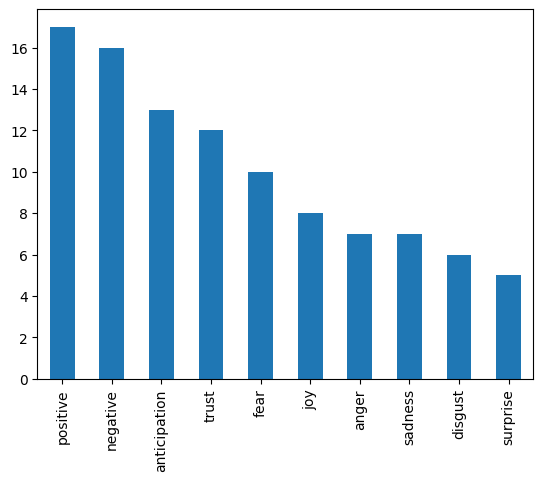

In [23]:
sentiment_result1.plot.bar()

- Dominant sentiments: Taller bars show which emotions appear most in the text.
- Complexity: High Positive and Negative together indicate a mixed, nuanced review.
- Nuance: Strong Anticipation and Trust suggest the reviewer was engaged and found parts credible despite criticisms.

### Analyzing the negative review with same steps

In [24]:
lines2

"The characters are unlikeable and the script is awful. It's a waste of the talents of Deneuve and Auteuil."

In [25]:
# Text Preprocessing  
# Normalize to lowercase and tokenize
raw = lines2.lower()
tokens = tokenizer.tokenize(raw)

In [26]:
# Remove stopwords
stopped_tokens = [i for i in tokens if not i in stop_words]

In [27]:
# Match with NRC Lexicon 
# Keep only words that exist in the NRC dictionary
match_words = [x for x in stopped_tokens if x in list(NRC[0])]

In [28]:
# Map Words to Emotions 
emotion = []
for i in match_words:
    # Retrieve all emotions associated with the current word 'i'
    temp = list(NRC.iloc[np.where(NRC[0] == i)[0], 1])
    for j in temp:
        emotion.append(j)

In [29]:
# Aggregate and Visualize 
# Count the frequency of each emotion
sentiment_result2 = pd.Series(emotion).value_counts()

In [30]:
# Display the statistical breakdown
print(sentiment_result2)

disgust     2
negative    2
positive    1
anger       1
fear        1
sadness     1
Name: count, dtype: int64


<Axes: >

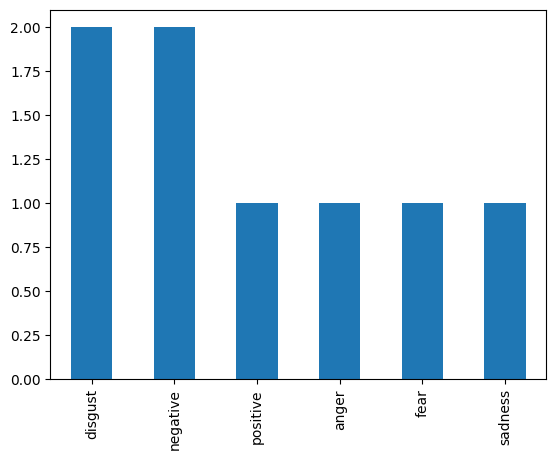

In [31]:
# Visualize the result as a bar chart
sentiment_result2.plot.bar()

- Review 1 (Positive/Complex): Mixed scores (Positive, Negative, Anticipation, Trust) show the reviewer liked the movie but had mixed feelings.
- Review 2 (Negative): Dominant Disgust and Negative indicate a clearly unfavorable review.
  
**Keywords**: Words such as "awful" and "waste" triggered the Disgust and Negative categories in NRC.

**Limitations of Lexicon Analysis**: Notice the count is very low. Short texts (lines2) provide fewer data points than long texts (lines1), making the statistical output less robust. Lexicon-based methods generally **work better with larger bodies of text.**

# Machine Learning-based Sentiment Analysis

### Machine Learning Approach vs. Lexicon Approach:

Previous (Lexicon): We looked up words in a pre-made dictionary (like Afinn). It is simple but cannot understand context or new slang.

Current (Machine Learning): We will teach the computer to recognize positive/negative patterns by feeding it thousands of examples. This requires much more data (12,500 reviews).

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load All Positive Review Paths 
# glob returns a list of ALL file paths matching the pattern *.txt in the 'pos' folder.
pos_review = (glob.glob(r"...\aclImdb\train\pos\*.txt"))

### Encoding – the rule that defines how numeric bytes should be interpreted as characters.

If a file is read with the wrong encoding:

- Characters appear broken (�)
- The file may fail to open
- Python may raise a UnicodeDecodeError

In [ ]:
lines_pos=[]
for i in pos_review:
    try:
        f = open(i, 'r', encoding='latin-1')
        temp = f.readlines()[0]
        lines_pos.append(temp)
        f.close()
    except Exception as e:
        continue

'latin-1' is more tolerant than 'utf-8'

In [ ]:
# Verify Data Loading 
# Check how many reviews were successfully loaded.
print(len(lines_pos)) 
# Output: 12500 (This matches the standard size of the ACL IMDB positive training set)

12500


In [ ]:
# Load Negative Reviews 
# Retrieve all file paths for negative reviews
neg_review = (glob.glob(r"...\aclImdb\train\neg\*.txt"))

lines_neg = []
for i in neg_review:
    try:
        f = open(i, 'r', encoding='latin-1')
        temp = f.readlines()[0]
        lines_neg.append(temp)
        f.close()
    except Exception as e:
        continue

# Verify length 
print(f"Negative reviews: {len(lines_neg)}")

Negative reviews: 12500


In [ ]:
# Create the Complete Corpus ---
# Combine positive and negative reviews into a single list for training
total_text = lines_pos + lines_neg

# Verify total length  
print(f"Total reviews: {len(total_text)}")

Total reviews: 25000


**Corpus Aggregation (total_text)**: In Machine Learning, we must train the model on the full picture. By combining lines_pos and lines_neg, we create a single dataset of 25,000 reviews.

### Create Labels (The "Answer Key")

In [ ]:
# Create an array with "pos" and "neg" labels matching the data size
x = np.array(["pos", "neg"])
class_Index = np.repeat(x, [len(lines_pos), len(lines_neg)], axis=0)

In [ ]:
# Verify the labels array
print(class_Index)

['pos' 'pos' 'pos' ... 'neg' 'neg' 'neg']


### TF-IDF Vectorization (Term Frequency - Inverse Document Frequency):

- Computers cannot understand text; they only understand numbers.
- TF-IDF converts text into a matrix of numbers. It gives high scores to unique, important words and low scores to common words.

In [ ]:
# Re-load stopwords
stop_words = stopwords.words('english')

In [ ]:
# Initialize the Vectorizer
# This tool will convert text into a matrix of numbers
vect = TfidfVectorizer(stop_words=stop_words)

In [ ]:
# Fit: Learn the vocabulary from the entire dataset
vect.fit(total_text)

TfidfVectorizer(stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...])

In [ ]:
# Transform: Convert the text documents into a TF-IDF matrix
X_train_vectorized = vect.transform(total_text)

In [ ]:
X_train_vectorized.index = class_Index 
# (This assigns the label 'pos'/'neg' to each row of the converted data)

### Inspecting the TF-IDF Matrix

In [ ]:
# Get the full list of words (features) the vectorizer learned from the reviews.
feature_names = vect.get_feature_names_out()

# Check a random slice of 50 words (from index 10,000 to 10,050)
# This helps verify if the cleaning worked or if there is garbage data.
print(feature_names[10000:10050])

['butterworth' 'buttgereit' 'butthead' 'butthorn' 'butting' 'buttock'
 'buttocks' 'button' 'buttonholes' 'buttons' 'buttress' 'buttresses'
 'butts' 'butz' 'butâ' 'bux' 'buxom' 'buxomed' 'buy' 'buyer' 'buyers'
 'buying' 'buyout' 'buyrate' 'buyruk' 'buys' 'buza' 'buzaglo' 'buzby'
 'buzz' 'buzzard' 'buzzards' 'buzzed' 'buzzell' 'buzzer' 'buzzes'
 'buzzing' 'buzzkill' 'buzzkirk' 'buzzsaw' 'buzzwords' 'buzzy' 'buã'
 'bvds' 'bw' 'bwahahahahha' 'bwahahha' 'bwainn' 'bwana' 'bwitch']


In [ ]:
# Convert to Dense Matrix for Visualization

# The vectorizer produces a 'Sparse Matrix' (compressed to save memory).
# .toarray() expands it into a standard full matrix so we can read it easily.
X_train_array = X_train_vectorized.toarray()

# Create a DataFrame
# Convert the matrix into a Pandas DataFrame for easy viewing.
# Rows = Individual Reviews
# Columns = Words (Feature Names)
tfidf_df = pd.DataFrame(X_train_array, columns=feature_names)

# Display the Matrix 
tfidf_df.head()

,00,000,0000000000001,00001,00015,000s,001,003830,006,007,...,zzzzzzzzzzzz,zzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zã,âº,â½,â¾,ã¼ber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**TF-IDF Matrix Overview**  
- **Rows**: each row is one review.  
- **Columns**: each column is one vocabulary word.  
- **Values**: TF-IDF importance scores (0.0 means the word is absent; higher means rare but important).  

**Sparsity**  
- The matrix is mostly zeros because reviews use very few words out of ~75,000 vocabulary terms.

# 1. Logistic Regression (The Baseline)
Logistic Regression is a classifier. It uses the Sigmoid function ($\sigma(z) = \frac{1}{1+e^{-z}}$) to squeeze the output between 0 and 1, representing the probability of a review being "Positive".

In [ ]:
from sklearn.linear_model import LogisticRegression 

In [ ]:
# Initialize and Train 
# Logistic Regression estimates the probability that a given input belongs to a certain class.
model = LogisticRegression()

# Fit the model to our vectorized training data (X) and the answer labels (class_Index)
model.fit(X_train_vectorized, class_Index)

LogisticRegression()

# 2. Decision Tree (The Interpretable Model)
A Decision Tree makes decisions by asking a series of "Yes/No" questions based on the words present in the text.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and Train
# max_depth=3: Limits the tree to only 3 levels deep. 
# This prevents "Overfitting" (memorizing the data too closely) and keeps the model simple.
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train_vectorized, class_Index)

DecisionTreeClassifier(max_depth=3)

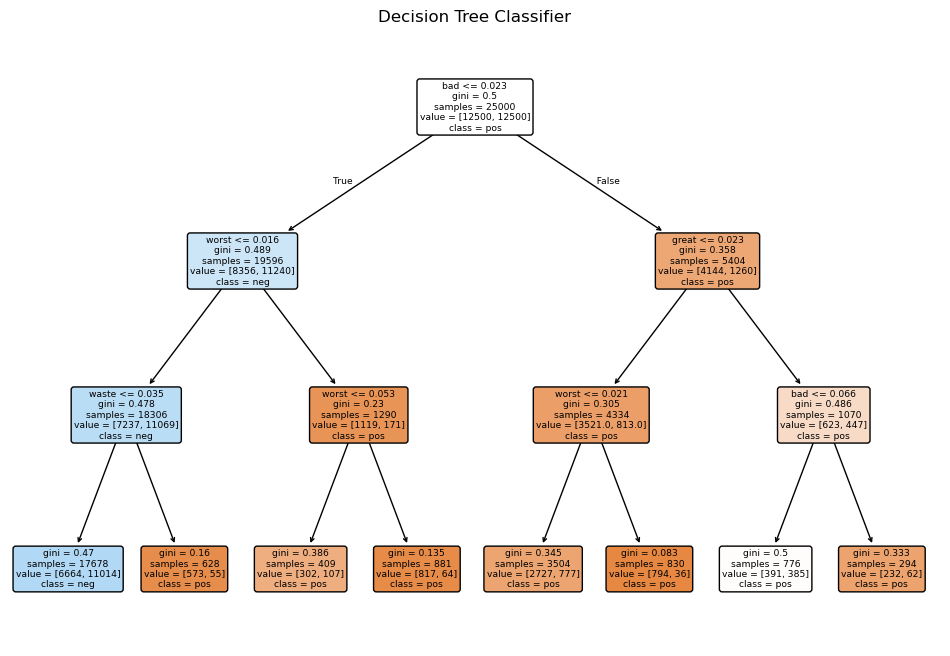

In [ ]:
# Visualize the Tree Structure 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
# plot_tree shows exactly which words (feature_names) splits the data at each node.
plot_tree(dtc, feature_names=feature_names, class_names=['pos', 'neg'], filled=True, rounded=True)
plt.title("Decision Tree Classifier")
plt.show()

The tree splits data based on "Information Gain". It looks for the word that best separates Positive reviews from Negative ones (e.g., if the word "bad" is present, go Left; if not, go Right).

# 3. Naive Bayes (The Probabilistic Model)
It is based on Bayes' Theorem. It calculates the probability of a review being positive given its words, assuming that the presence of one word is independent of the others (hence "Naive").

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and Train 
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, class_Index)

MultinomialNB()

# 4. Multi-Layer Perceptron (MLP)
This is a basic form of a Neural Network (Deep Learning).

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize and Train 
mlp_model = MLPClassifier(hidden_layer_sizes=(2, 2), max_iter=100, random_state=42)
mlp_model.fit(X_train_vectorized, class_Index)

# hidden_layer_sizes=(2, 2): A small network with 2 hidden layers, each having 2 neurons.
# max_iter=100: The model will update its weights at most 100 times.
# random_state=42: Ensures the result is reproducible.

MLPClassifier(hidden_layer_sizes=(2, 2), max_iter=100, random_state=42)

# 5. Support Vector Machine (SVM)
SVM tries to find the widest possible gap (margin) between the two classes. The "Support Vectors" are the data points closest to the boundary that determine the line's position.

In [ ]:
from sklearn.svm import SVC

# Initialize and Train
clf = SVC(kernel='linear')
clf.fit(X_train_vectorized, class_Index)

# kernel='linear': Uses a straight line (or hyperplane) to separate the data.
# This is usually the best setting for text data.

SVC(kernel='linear')

# Loading the Test Data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Load Positive Test Reviews ---
pos_review_test = (glob.glob(r"...\aclImdb\test\pos\*.txt"))

lines_pos_test = []
for i in pos_review_test:
    try:
        f = open(i, 'r', encoding='latin-1')
        temp = f.readlines()[0]
        lines_pos_test.append(temp)
        f.close()
    except Exception as e:
        continue

# Load Negative Test Reviews ---
neg_review_test = (glob.glob(r"...\aclImdb\test\neg\*.txt"))

lines_neg_test = []
for i in neg_review_test:
    try:
        f = open(i, 'r', encoding='latin-1')
        temp = f.readlines()[0]
        lines_neg_test.append(temp)
        f.close()
    except Exception as e:
        continue

# Verify lengths
print(f"Positive Test: {len(lines_pos_test)}, Negative Test: {len(lines_neg_test)}")

Positive Test: 12500, Negative Test: 12500


In [ ]:
# Combine and Label Test Data
total_text_test = lines_pos_test + lines_neg_test

In [ ]:
# Create the answer key for the test set
x = np.array(["pos", "neg"])
class_Index_test = np.repeat(x, [len(lines_pos_test), len(lines_neg_test)], axis=0)

In [ ]:
# Vectorize Test Data 
X_test_vectorized = vect.transform(total_text_test)

**fit() vs transform()**  
- For test data, always use **transform()**, never **fit()**.  
- **fit()** builds a new vocabulary, which would mismatch the training dictionary and break predictions.  
- **transform()** ensures test data is encoded using the same vocabulary learned during training.

In [ ]:
# Assign index for consistency
X_test_vectorized.index = class_Index_test

# Evaluation

In [ ]:
# Import Metrics & Tools 
# accuracy_score: Calculates the % of correct answers.
# confusion_matrix: Shows True Positives, False Positives, etc.
# roc_curve / roc_auc_score: Advanced metrics for binary classification.

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns # Used for nicer visualizations
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode Labels for ROC 
# ROC curves require numerical labels (0 and 1), not strings ("pos", "neg").
le = LabelEncoder()

**Why LabelEncoder?**  
- ROC Curve requires numeric labels to test different thresholds.  
- Text labels like "pos"/"neg" cannot be thresholded, so we convert them to **0** (negative) and **1** (positive).


In [ ]:
y_test_num = le.fit_transform(class_Index_test) 
# Now "neg" -> 0 and "pos" -> 1 (or vice versa, depending on alphabetical order)

In [ ]:
# Group Models for Loop 
# Store all trained models in a dictionary for easy iteration.

models = {
    "Logistic Regression": model,
    "Decision Tree": dtc,
    "Naive Bayes": nb_model,
    "MLP": mlp_model,
    "SVM": clf
}


=== Logistic Regression ===
Accuracy: 0.8831
Confusion Matrix:
[[11052  1448]
 [ 1474 11026]]
ROC-AUC: 0.9523

=== Decision Tree ===
Accuracy: 0.6752
Confusion Matrix:
[[ 5844  6656]
 [ 1464 11036]]
ROC-AUC: 0.6854

=== Naive Bayes ===
Accuracy: 0.8341
Confusion Matrix:
[[11009  1491]
 [ 2657  9843]]
ROC-AUC: 0.9162

=== MLP ===
Accuracy: 0.8515
Confusion Matrix:
[[11347  1153]
 [ 2560  9940]]
ROC-AUC: 0.9326

=== SVM ===
Accuracy: 0.8779
Confusion Matrix:
[[11110  1390]
 [ 1662 10838]]
ROC-AUC: 0.9491


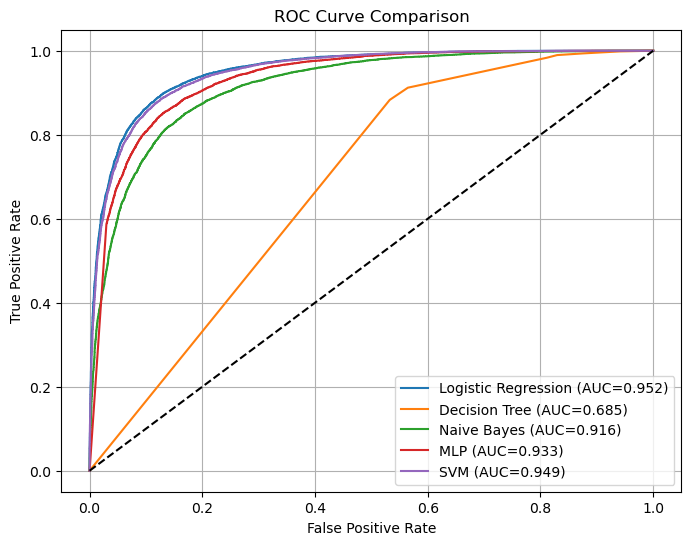

In [ ]:
# Run Evaluation & Plotting 
plt.figure(figsize=(8,6))

# Iterate through each model in our dictionary
for name, clf_model in models.items():
    
    # a) Predict the classes (Pos/Neg)
    y_pred = clf_model.predict(X_test_vectorized)
    
    # Convert predictions to numbers (needed for accuracy check against y_test_num)
    y_pred_num = le.transform(y_pred)
    
    # b) Calculate Probability Scores (Needed for ROC Curve)
    # Some models (SVM) use .decision_function(), others use .predict_proba().
    # This try/except block handles both cases automatically.
    try:
        # Get probability of class '1' (Positive)
        y_prob = clf_model.predict_proba(X_test_vectorized)[:, 1]
    except:
        # For models like SVM without probability=True
        y_prob = clf_model.decision_function(X_test_vectorized)

    # c) Calculate Metrics
    acc = accuracy_score(y_test_num, y_pred_num)
    cm = confusion_matrix(y_test_num, y_pred_num)
    auc = roc_auc_score(y_test_num, y_prob)

    # d) Print Results
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"ROC-AUC: {auc:.4f}")

    # e) Plot ROC Curve
    # fpr = False Positive Rate, tpr = True Positive Rate
    fpr, tpr, _ = roc_curve(y_test_num, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

# Finalize Plot 
# Add a dashed line representing a "Random Guess" (50% accuracy)
plt.plot([0,1], [0,1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

### The Metrics 

* **Accuracy:** The percentage of total answers the model got right.
    * *Formula:* (Correct Answers) / (Total Questions).
    * *Meaning:* If Accuracy is **0.88** (like your Logistic Regression), the model is correct **88%** of the time.
* **Confusion Matrix:** A table that breaks down *where* the model made mistakes.
    * It shows four values:
        1.  **True Positive:** Correctly identified a Positive review.
        2.  **True Negative:** Correctly identified a Negative review.
        3.  **False Positive (Type I Error):** The model said it was "Good," but it was actually "Bad."
        4.  **False Negative (Type II Error):** The model said it was "Bad," but it was actually "Good."
    * *Meaning:* It helps you see if the model is biased (e.g., does it hate everything?).

* **ROC-AUC (Area Under Curve):** A single grade from 0 to 1 that measures the model's ability to distinguish between classes.
    * **0.5:** The model is guessing randomly (useless).
    * **1.0:** The model is perfect.
    * *Meaning:* Your Logistic Regression scored **0.95**, which is an "A+" grade. It is very good at separating positive reviews from negative ones.

---

### How to Read the ROC Curve Plot

The ROC Curve visualizes the trade-off between capturing true positives and accidentally flagging false positives.

**The Axes:**
* **Y-Axis (True Positive Rate):** "Sensitivity." How many of the *actual* positive reviews did we catch? (Higher is better).
* **X-Axis (False Positive Rate):** "False Alarm Rate." How many negative reviews did we incorrectly call positive? (Lower is better).

**The Shapes:**
1.  **The Diagonal Dashed Line:** This represents **Random Guessing** (like flipping a coin). If a curve follows this line, the model learned nothing.
2.  **The "Elbow":** The curve should shoot up quickly and then flatten out.
3.  **Top-Left Corner:** This is the "Perfect" zone. It means 100% True Positives and 0% False Alarms.

**Analyzing Your Plot:**
* **Best Model:** The **Blue Line (Logistic Regression)**. Notice how it arches highest and hugs the top-left corner tightest.
* **Worst Model:** The **Orange Line (Decision Tree)**. It is much lower and closer to the diagonal line, meaning it makes many more mistakes compared to the others.

 
    "Logistic Regression": model,
    "Decision Tree": dtc,
    "Naive Bayes": nb_model,
    "MLP": mlp_model,
    "SVM": clf
 

In [ ]:
# Predict Sentiment of New Text 

def predict_my_sentence(text):
    # Transform the text using the SAME vectorizer trained earlier
    vectorized_text = vect.transform([text])
    
    # Predict using the best model (Logistic Regression) 
    prediction = model.predict(vectorized_text)
    
    # Output the result
    return f"Input: '{text}' -> Sentiment: {prediction[0]}"

# Test with custom examples
print(predict_my_sentence("This movie was absolutely fantastic and I loved it."))
print(predict_my_sentence("I wasted 2 hours of my life, it was terrible."))
print(predict_my_sentence("The plot was okay, but the acting was bad."))

Input: 'This movie was absolutely fantastic and I loved it.' -> Sentiment: pos
Input: 'I wasted 2 hours of my life, it was terrible.' -> Sentiment: neg
Input: 'The plot was okay, but the acting was bad.' -> Sentiment: neg
